<a href="https://colab.research.google.com/github/LuluW8071/sign-lang-detection-using-lstm/blob/main/model/PyTorch_CNN_Nepali_Consonant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cuda


In [2]:
!nvidia-smi

Thu Mar  7 16:14:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              14W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get Data
#### [Download Datasets](https://drive.google.com/file/d/1d2k7qfTOoUDSO1TFBlX7GvSLWnPLOoCj/view?usp=sharing)

Just click the link then download the dataset and upload on your drive. Then you can copy to colab runtime and work on it.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import shutil
import os
from tqdm import tqdm

# Path to the file in Google Drive
source_file = '/content/drive/My Drive/Datasets/Nepali_Consonants.zip'

# Destination path in Google Colab runtime
destination_folder = '/content/'
file_size = os.path.getsize(source_file)

with open(source_file, 'rb') as fsrc, open(os.path.join(destination_folder, 'Nepali_Consonants.zip'), 'wb') as fdst:
    with tqdm(total=file_size, desc='Copying file', unit='B', unit_scale=True) as pbar:
        while True:
            buf = fsrc.read(1024 * 1024)  # Read 1 MB at a time
            if not buf:
                break
            fdst.write(buf)
            pbar.update(len(buf))

print("File copied successfully.")

Copying file: 100%|██████████| 1.51G/1.51G [00:21<00:00, 70.8MB/s]

File copied successfully.


In [5]:
import zipfile

zip_file_path = '/content/Nepali_Consonants.zip'
extract_folder = '/content/'

# Create the extraction folder if it doesn't exist
os.makedirs(extract_folder, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Extraction completed successfully.")

Extraction completed successfully.


In [6]:
from pathlib import Path

# Setup path to data folder
image_path = Path("/content/Nepali_Consonants")

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in '/content/Nepali_Consonants'.
There are 36 directories and 0 images in '/content/Nepali_Consonants/test'.
There are 0 directories and 25 images in '/content/Nepali_Consonants/test/क्ष'.
There are 0 directories and 25 images in '/content/Nepali_Consonants/test/ञ'.
There are 0 directories and 21 images in '/content/Nepali_Consonants/test/ष'.
There are 0 directories and 25 images in '/content/Nepali_Consonants/test/ह'.
There are 0 directories and 25 images in '/content/Nepali_Consonants/test/ठ'.
There are 0 directories and 25 images in '/content/Nepali_Consonants/test/ख'.
There are 0 directories and 25 images in '/content/Nepali_Consonants/test/क'.
There are 0 directories and 25 images in '/content/Nepali_Consonants/test/र'.
There are 0 directories and 25 images in '/content/Nepali_Consonants/test/व'.
There are 0 directories and 15 images in '/content/Nepali_Consonants/test/ज्ञ'.
There are 0 directories and 25 images in '/content/Nepali_Consonants/t

## 2. Data Preparation (Visualization)

Random image path: /content/Nepali_Consonants/train/ढ/hand_0101.png
Image Class: ढ
Image Height: 173
Image Width: 264


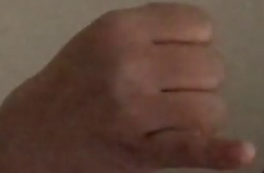

In [7]:
import random
from PIL import Image

# random.seed(42)
image_path_list = list(image_path.glob("*/*/*.png"))
# print(len(image_path_list))
random_image_path = random.choice(image_path_list)
# print(random_image_path)
# the image class is the name of the directory where iamges resides
image_class = random_image_path.parent.stem
# print(image_class)

img = Image.open(random_image_path)

# Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image Class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image Width: {img.width}')
img

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2338 (\N{DEVANAGARI LETTER DDHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


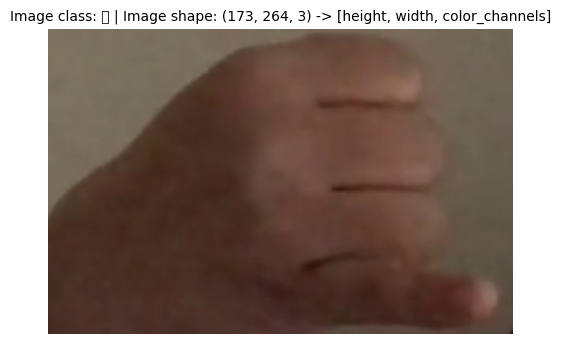

In [8]:
# Visualizing using matplotliib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
fig = plt.figure(figsize=(6, 5))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]", fontsize = 10)
plt.axis(False)
plt.show()

array([[[126, 115,  98],
        [126, 115,  98],
        [126, 115,  98],
        ...,
        [111, 100,  85],
        [112, 101,  86],
        [112, 101,  86]],

       [[126, 115,  98],
        [126, 115,  98],
        [126, 115,  98],
        ...,
        [111, 100,  85],
        [112, 101,  86],
        [112, 101,  86]],

       [[125, 114,  97],
        [125, 114,  97],
        [125, 114,  97],
        ...,
        [111, 100,  85],
        [112, 101,  86],
        [112, 101,  86]],

       ...,

       [[ 65,  42,  31],
        [ 67,  41,  31],
        [ 69,  43,  33],
        ...,
        [ 83,  70,  65],
        [ 78,  65,  60],
        [ 69,  56,  53]],

       [[ 67,  44,  33],
        [ 69,  43,  33],
        [ 70,  44,  34],
        ...,
        [ 81,  68,  63],
        [ 71,  58,  53],
        [ 53,  40,  37]],

       [[ 67,  44,  33],
        [ 69,  43,  33],
        [ 70,  44,  34],
        ...,
        [ 74,  61,  58],
        [ 59,  46,  43],
        [ 37,  28,  24]]], dtype=uint8)
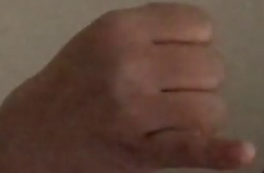

In [9]:
img_as_array

## 3. Transforming data

In [10]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

print(torchvision.__version__)

# Transform image
data_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),         # Resize our images to 224x224
    transforms.ToTensor()
])


transformed_data = data_transform(img)
transformed_data, transformed_data.shape, transformed_data.dtype

0.16.0+cu121


(tensor([[[0.4941, 0.4941, 0.4941,  ..., 0.4353, 0.4392, 0.4392],
          [0.4941, 0.4941, 0.4941,  ..., 0.4353, 0.4392, 0.4392],
          [0.4941, 0.4941, 0.4941,  ..., 0.4353, 0.4392, 0.4392],
          ...,
          [0.2588, 0.2706, 0.2745,  ..., 0.3255, 0.3020, 0.2471],
          [0.2627, 0.2706, 0.2745,  ..., 0.3137, 0.2784, 0.2039],
          [0.2627, 0.2706, 0.2745,  ..., 0.3020, 0.2510, 0.1608]],
 
         [[0.4510, 0.4510, 0.4510,  ..., 0.3922, 0.3961, 0.3961],
          [0.4510, 0.4510, 0.4510,  ..., 0.3922, 0.3961, 0.3961],
          [0.4510, 0.4510, 0.4510,  ..., 0.3922, 0.3961, 0.3961],
          ...,
          [0.1686, 0.1686, 0.1725,  ..., 0.2706, 0.2510, 0.1961],
          [0.1725, 0.1686, 0.1725,  ..., 0.2627, 0.2275, 0.1569],
          [0.1725, 0.1686, 0.1725,  ..., 0.2510, 0.2000, 0.1255]],
 
         [[0.3843, 0.3843, 0.3843,  ..., 0.3333, 0.3373, 0.3373],
          [0.3843, 0.3843, 0.3843,  ..., 0.3333, 0.3373, 0.3373],
          [0.3843, 0.3843, 0.3843,  ...,

## 4. Loading data with `ImageFolder`

In [11]:
# Setup train and test paths
train_dir = 'Nepali_Consonants/train'
test_dir = 'Nepali_Consonants/test'

train_dir, test_dir

('Nepali_Consonants/train', 'Nepali_Consonants/test')

In [12]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # Transforms input data into tensors
                                  target_transform = None)  # Transform labels into none

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data


(Dataset ImageFolder
     Number of datapoints: 7981
     Root location: Nepali_Consonants/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 886
     Root location: Nepali_Consonants/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [13]:
# Get class names as lists and then convert to dict
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_dict

{'क': 0,
 'क्ष': 1,
 'ख': 2,
 'ग': 3,
 'घ': 4,
 'ङ': 5,
 'च': 6,
 'छ': 7,
 'ज': 8,
 'ज्ञ': 9,
 'झ': 10,
 'ञ': 11,
 'ट': 12,
 'ठ': 13,
 'ड': 14,
 'ढ': 15,
 'ण': 16,
 'त': 17,
 'त्र': 18,
 'थ': 19,
 'द': 20,
 'ध': 21,
 'न': 22,
 'प': 23,
 'फ': 24,
 'ब': 25,
 'भ': 26,
 'म': 27,
 'य': 28,
 'र': 29,
 'ल': 30,
 'व': 31,
 'श': 32,
 'ष': 33,
 'स': 34,
 'ह': 35}

In [14]:
train_data.samples[:8000:1050]

[('Nepali_Consonants/train/क/hand_0000.png', 0),
 ('Nepali_Consonants/train/घ/hand_0170.png', 4),
 ('Nepali_Consonants/train/ज्ञ/hand_0083.png', 9),
 ('Nepali_Consonants/train/ड/hand_0091.png', 14),
 ('Nepali_Consonants/train/थ/hand_0008.png', 19),
 ('Nepali_Consonants/train/प/hand_342.png', 23),
 ('Nepali_Consonants/train/य/hand_15.png', 28),
 ('Nepali_Consonants/train/ष/hand_0007.png', 33)]

In [15]:
# Index on the train_data Dataset to get a single iamge and label
img, label = train_data[0][0], train_data[0][1]

img, img.dtype, label, type(label), class_names[label]

(tensor([[[0.7725, 0.7765, 0.7804,  ..., 0.7529, 0.7490, 0.7490],
          [0.7725, 0.7765, 0.7804,  ..., 0.7529, 0.7490, 0.7490],
          [0.7725, 0.7804, 0.7804,  ..., 0.7529, 0.7490, 0.7490],
          ...,
          [0.4510, 0.4510, 0.4510,  ..., 0.6627, 0.6588, 0.6549],
          [0.4471, 0.4549, 0.4510,  ..., 0.6627, 0.6588, 0.6549],
          [0.4510, 0.4510, 0.4510,  ..., 0.6627, 0.6588, 0.6549]],
 
         [[0.7451, 0.7490, 0.7529,  ..., 0.7451, 0.7412, 0.7412],
          [0.7451, 0.7490, 0.7529,  ..., 0.7451, 0.7412, 0.7412],
          [0.7451, 0.7529, 0.7529,  ..., 0.7412, 0.7373, 0.7373],
          ...,
          [0.3569, 0.3569, 0.3569,  ..., 0.6510, 0.6510, 0.6510],
          [0.3529, 0.3608, 0.3529,  ..., 0.6510, 0.6510, 0.6510],
          [0.3569, 0.3569, 0.3529,  ..., 0.6510, 0.6510, 0.6510]],
 
         [[0.6392, 0.6431, 0.6471,  ..., 0.6314, 0.6275, 0.6275],
          [0.6392, 0.6431, 0.6471,  ..., 0.6314, 0.6275, 0.6275],
          [0.6392, 0.6471, 0.6471,  ...,

In [16]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)
img.shape, img_permute.shape

(torch.Size([3, 224, 224]), torch.Size([224, 224, 3]))

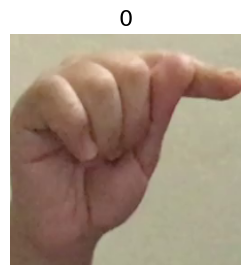

In [17]:
# Plot the image
plt.figure(figsize = (3, 3))
plt.imshow(img_permute)
plt.axis("off")
plt.title(label, fontsize = 16);  # Can't use class_names[label] cuz it is not standard font in matplotlib

## 5. Turn loaded images into Dataloaders

In [18]:
# Train and test dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

len(train_dataloader), len(test_dataloader)

(250, 28)

In [19]:
img, label = next(iter(train_dataloader))

img.shape, label.shape     # {img.shape} -> [batch_size, color_channels, height, width]

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## 6. Transfer Learning using `EfficientNetB0`

In [20]:
!pip install efficientnet_pytorch torchinfo

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=ed07418572caaafc06b8c2568d354ae145ae59990c29d6c63a24223145e26440
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


<img src = "https://www.researchgate.net/publication/357622806/figure/fig2/AS:1119949779144707@1644028243890/EfficientNetB0-architecture-36.png">

In [27]:
from efficientnet_pytorch import EfficientNet
from torchinfo import summary

num_classes = 36    # Number of classes

# Instantiate the EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0').to(device)
model._fc = nn.Linear(model._fc.in_features, num_classes)          # Modify the output shape

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Loaded pretrained weights for efficientnet-b0


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 36]             --                   True
├─Conv2dStaticSamePadding (_conv_stem)                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    └─ZeroPad2d (static_padding)                            [32, 3, 224, 224]    [32, 3, 225, 225]    --                   --
├─BatchNorm2d (_bn0)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
├─MemoryEfficientSwish (_swish)                              [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─ModuleList (_blocks)                                       --                   --                   --                   True
│    └─MBConvBlock (0)                                       [32, 32, 112, 112]   [32, 16, 112, 

In [28]:
# Trying forward pass to check the model
model(img.to(device))

tensor([[-0.1785,  0.0594, -0.0373,  ..., -0.3873, -0.0144, -0.1134],
        [-0.2647, -0.2729, -0.1171,  ..., -0.1412, -0.3300, -0.0076],
        [ 0.0786, -0.1011,  0.0998,  ..., -0.3336, -0.0644, -0.1104],
        ...,
        [-0.1022, -0.0236, -0.2979,  ..., -0.1150, -0.0676,  0.0548],
        [-0.1522,  0.2052,  0.1667,  ..., -0.0464, -0.1307,  0.1078],
        [-0.0050, -0.2318, -0.0239,  ..., -0.2018, -0.3454, -0.0426]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

## 7. Create Train/Test Loop Function

In [29]:
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss, test_acc = 0, 0

    # Turn on inference
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [30]:
from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs):

  # Create a empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss":[],
             "test_acc": []}

  # Loop through training and testing steps for no of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       optimizer = optimizer,
                                       loss_fn = loss_fn)

    test_loss, test_acc = test_step(model = model,
                                     dataloader = test_dataloader,
                                     loss_fn = loss_fn)

    print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} - Train acc: {(train_acc*100):.2f}% -  Test loss: {test_loss:.4f} - Test acc: {(test_acc*100):.2f}%')

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

## 8. Train and Evaluate the Model

In [31]:
# Setup loss functions and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.001)

In [33]:
# Set random seed
# torch.manual_seed(42)
EPOCHS = 5

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model = model,
                      train_dataloader = train_dataloader,
                      test_dataloader = test_dataloader,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      epochs = EPOCHS)

# End the timer and print duration of training
end_time = timer()
print(f'Total Train Time: {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.2940 - Train acc: 93.49% -  Test loss: 1.3685 - Test acc: 58.82%
Epoch: 1 | Train loss: 0.0342 - Train acc: 99.20% -  Test loss: 0.0066 - Test acc: 99.89%
Epoch: 2 | Train loss: 0.0248 - Train acc: 99.46% -  Test loss: 0.0765 - Test acc: 98.77%
Epoch: 3 | Train loss: 0.0337 - Train acc: 99.13% -  Test loss: 0.0638 - Test acc: 98.21%
Epoch: 4 | Train loss: 0.0280 - Train acc: 99.29% -  Test loss: 0.0320 - Test acc: 99.55%
Total Train Time: 447.103 seconds


## 9. Plot loss curves and accuracy curves

In [35]:
# Get the model key results
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [36]:
def plot_loss_curves(results):
    """ Plots training curves of a results dictionary """

    # Get results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

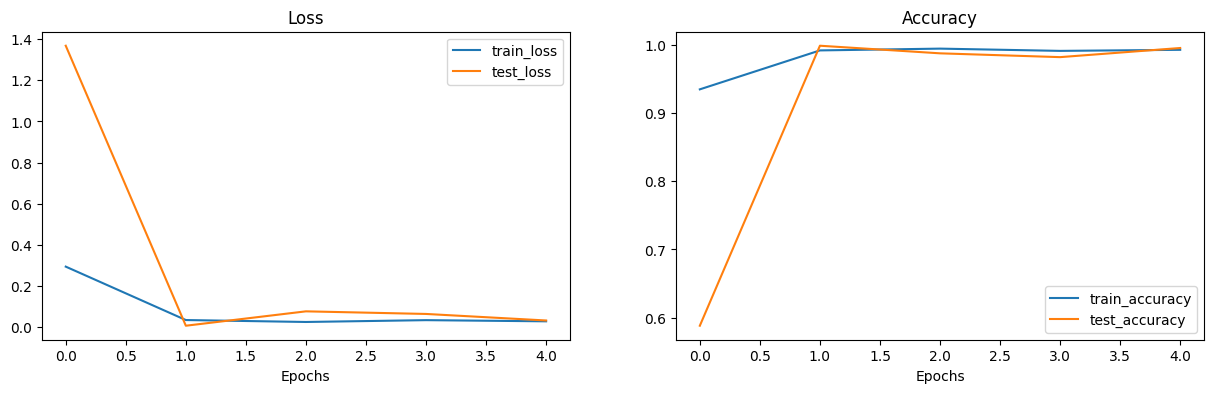

In [37]:
plot_loss_curves(model_results)

## 10. Saving Model

In [38]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME = "NepaliHandSignClassifier.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/NepaliHandSignClassifier.pth


In [40]:
loaded_model = EfficientNet.from_pretrained('efficientnet-b0').to('cpu')
loaded_model._fc = nn.Linear(model._fc.in_features, 36)

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded pretrained weights for efficientnet-b0
Model on device:
cpu


## 12. Making Predictions on Loaded Model

In [51]:
def make_predictions(model, data, device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim = 0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [56]:
import random
# random.seed(42)

test_samples = []
test_labels = []
# test_targets_tensor = torch.tensor(test_data.targets)
for sample, label in random.sample(list(test_data), k = 30):
  test_samples.append(sample)
  test_labels.append(label)

In [57]:
test_samples[0].shape

torch.Size([3, 224, 224])

In [58]:
loaded_pred_probs = make_predictions(loaded_model,
                                     test_samples,
                                     device)

loaded_pred_classes = loaded_pred_probs.argmax(dim = 1)

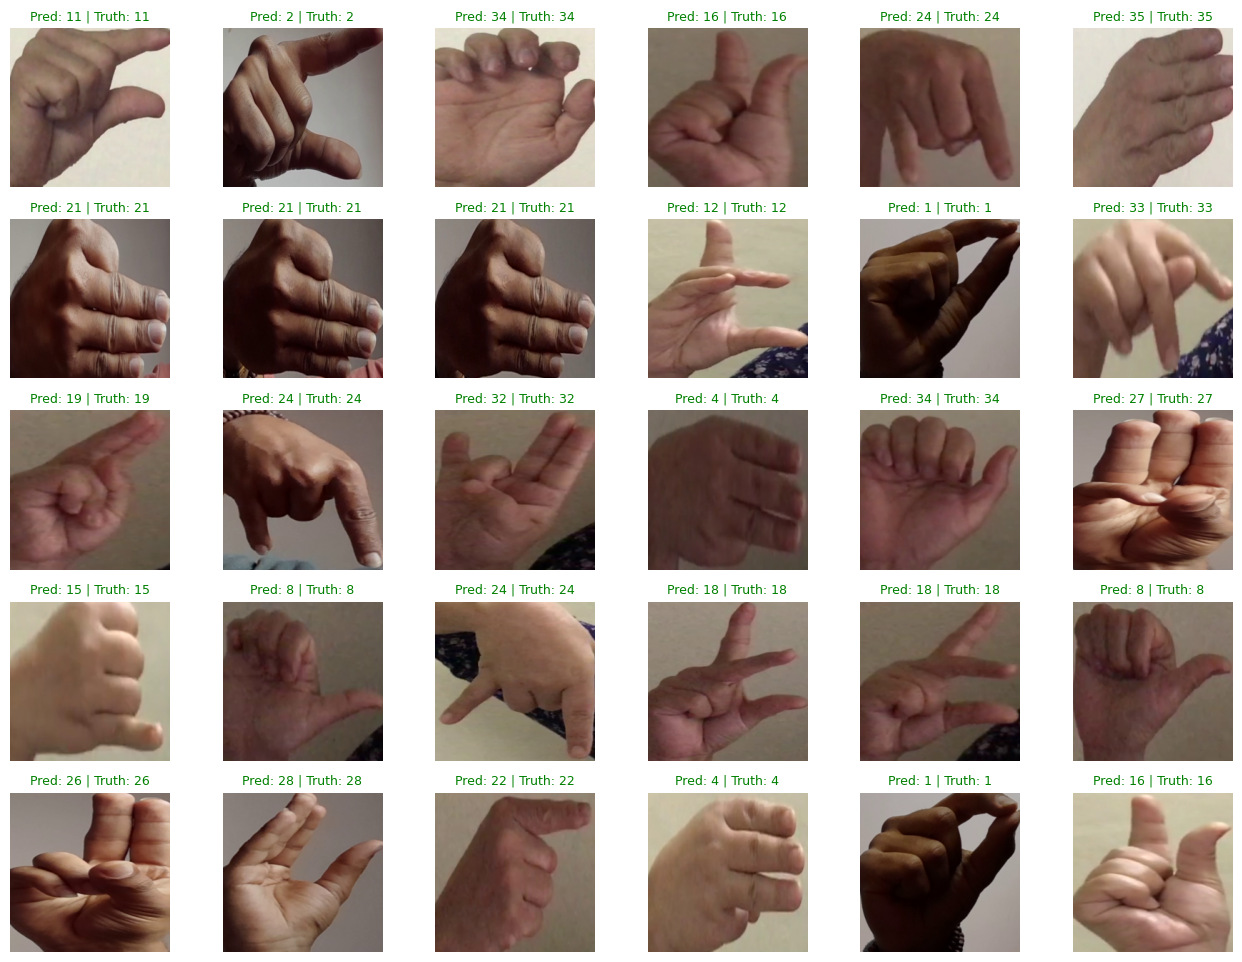

In [59]:
plt.figure(figsize=(16, 12))
nrows, ncols = 5, 6

for i, sample in enumerate(test_samples):
  class_name = np.array(['क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ',
                          'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ',
                          'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'क्ष', 'त्र', 'ज्ञ'])
  plt.subplot(nrows, ncols, i + 1)
  normalized_sample = sample.permute(1, 2, 0).numpy()
  # normalized_sample = normalized_sample / 255.0
  plt.imshow(normalized_sample)

  pred_label = class_name[loaded_pred_classes[i]]
  truth_label = class_name[test_labels[i]]
  title_text = f"Pred: {loaded_pred_classes[i]} | Truth: {test_labels[i]}"    # Printed index instead of characters cuz matplotlib doesnt recognize nepali fonts

  if pred_label == truth_label:
      plt.title(title_text, fontsize=9, c="g")
  else:
      plt.title(title_text, fontsize=9, c="r")

  plt.axis(False);